# Get Pinkberry locations

#### Load Python tools and Jupyter config

In [1]:
%load_ext lab_black

In [2]:
import re
import json
import requests
import pandas as pd
import geopandas as gpd
from bs4 import BeautifulSoup
from tqdm.notebook import tqdm, trange

In [3]:
pd.options.display.max_rows = 1000
pd.options.display.max_columns = 1000
pd.options.display.max_colwidth = None

## Read data

#### Snag store locations from inline json [on this map](https://locator.kahalamgmt.com/locator/index.php?brand=24&mode=map)

In [4]:
data_list = []

response = requests.get(
    f"https://locator.kahalamgmt.com/locator/index.php?brand=24&mode=map&latitude=34.00125000&longitude=-118.43066000&q=90066&pagesize=1000"
)
soup = BeautifulSoup(response.text, "html.parser")
stores_list = soup.findAll("script", type="text/javascript")[1:72]

for s in stores_list:
    script_content = s.string.replace(
        "// generated by including pagesize parameter", ""
    )
    match = re.search(r"Locator\.stores\['\d+'\] = ({.*?});", script_content)
    if match:
        json_content = match.group(1)

        # Load JSON content into a dictionary
        store_data = json.loads(json_content)
        data_list.append(store_data)
    else:
        print(f"No JSON content found in script: {script_content}")

In [5]:
src = pd.DataFrame(data_list)
src.columns = src.columns.str.lower()

In [6]:
df = src[
    [
        "storeid",
        "latitude",
        "longitude",
        "address",
        "city",
        "state",
        "statename",
        "zip",
        "phone",
        "locationtype",
    ]
].copy()

In [7]:
df.head()

,storeid,latitude,longitude,address,city,state,statename,zip,phone,locationtype
0,15047,33.979537,-118.438612,"4708 1/2 Admiralty Way, #A-3",Marina del Rey,CA,California,90292,(310) 827-3900,Street Front
1,15180,33.985441,-118.395128,6000 Sepulveda Blvd,Culver City,CA,California,90230,(310) 390-2333,Mall
2,15037,34.033976,-118.492749,"1612 Montana Ave,",Santa Monica,CA,California,90403,(310) 264-4791,Street Front
3,15329,33.941589,-118.408530,"1 World Way, LAX,",Los Angeles,CA,California,90045,,Airport
4,15020,34.063521,-118.398896,"240 S Beverly Dr, #A",Beverly Hills,CA,California,90212,(310) 734-7543,Street Front


---

## Geography

#### Make a geodataframe from lon/lat

In [8]:
df_geo = df.copy()

In [9]:
gdf = gpd.GeoDataFrame(
    df_geo, geometry=gpd.points_from_xy(df_geo.longitude, df_geo.latitude)
).set_crs("epsg:4326")

<AxesSubplot: >

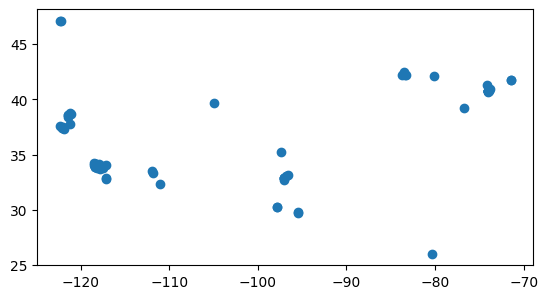

In [10]:
gdf.plot()

---

## Exports

#### CSV

In [11]:
df.to_csv("data/processed/pinkberry_locations.csv", index=False)

#### JSON

In [12]:
df.to_json("data/processed/pinkberry_locations.json", indent=4, orient="records")

#### GeoJSON

In [13]:
gdf.to_file("data/processed/pinkberry_locations.geojson", driver="GeoJSON")